# Orientation Preference Maps

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import filters
import scipy.stats as ss

from opm import make_opm, plot_opm, plot_amplitude_map, calculate_map
from opm.response import response, create_stimuli, compute_responses

## Ground truth map
We first create a "ground truth" orientation preference map. The real part a(x) and the imaginary part b(x) are created as standard Gaussian white noise, which is then convoluted with a difference of Gaussians filter (equations are analogous for b(x)):

$ \tilde{a}(x) = \mathcal{N}(0, 1) $

$
a(x) = \tilde{a}(x) * \mathcal{N}(x \;|\; 0, \sigma^2) - \tilde{a}(x) * \mathcal{N}(x \;|\; 0, k \sigma^2)
$

The orientation preference map is then

$ m(x) = a(x) + i b(x)  = A(x) \; exp[2i \, \theta(x)]$, 

where $A(x)$ is the absolute value of $m(x)$ and $2 \theta(x)$ is the argument of $m(x)$.

The pinwheels are detected as zero-crossings of the real and imaginary parts of the map.

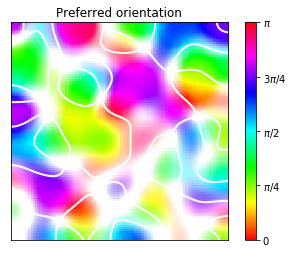

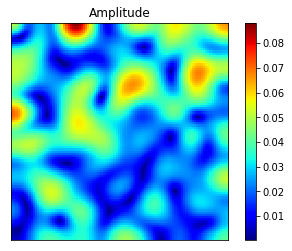

In [2]:
m = make_opm(size=100, sigma=8.)

f, ax = plot_opm(m, shade=True, rmax=80)

plt.show()

f, ax = plot_amplitude_map(m)

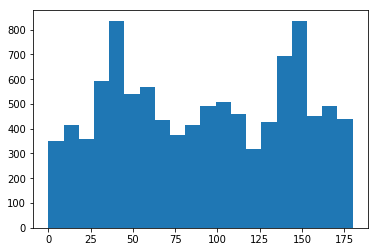

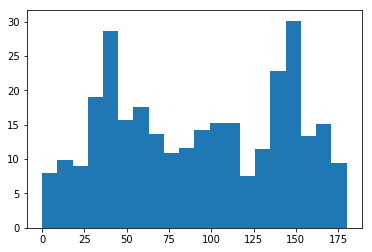

In [3]:
def plot_orientation_histogram(m, weighted=False, bins=20, ax=None):
    if not ax:
        f, ax = plt.subplots()
        
    weights = np.abs(m).reshape(-1) if weighted else None
    
    ax.hist((np.angle(m).reshape(-1) + np.pi) / (2 * np.pi) * 180, bins=bins, weights=weights)
    
    return f, ax
    

plot_orientation_histogram(m)
plt.show()

plot_orientation_histogram(m, weighted=True)
plt.show()

## Response model
Now we want to model the response to a stimulus

$\mathbf{s} = \begin{pmatrix}s_1 \\ s_2\end{pmatrix}$ with  $s_1 + s_2 = c_s \; exp(2i \, \theta_s)$,

where $c_s$ is the contrast of the stimulus and $\theta_s$ is the orientation of the stimulus.

We assume that the response at the pixel x is a linear function of the real and imaginary parts of the orientation map with additional Gaussian noise $\epsilon$ with variance $\sigma^2_n$:

$ r(x, s) = a(x) \, s_1(x) + b(x) \, s_2(x) + c + \epsilon \\
  = A \, cos(2\theta) \, c_s \, cos(2\theta_s) + A \, sin(2\theta) \, c_s \, sin(2\theta_s) + c + \epsilon
 $
 
Applying $ cos(\alpha - \beta) = cos(\alpha) cos(\beta) + sin(\alpha) sin(\beta) $, we obtain

$ r(x, s) = A \, c_s \, cos(2(\theta - \theta_s)) + c + \epsilon $

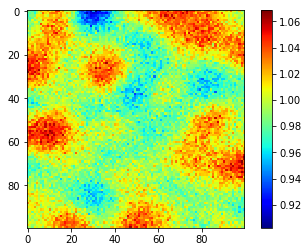

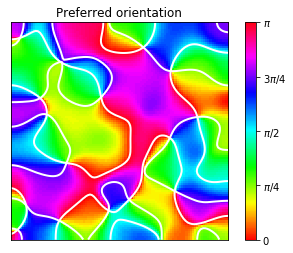

In [6]:
# we now assume we observe a stimulus with contrast c_s and orientation theta_s
c_s = 1.0
theta_s = 2 * np.pi / 4 - np.pi / 2

r = response(m, c_s, theta_s, c=1., sigma=0.01)

# plot response
im = plt.imshow(r, cmap='jet')
#im.set_clim(.7, 1.2)
plt.colorbar()

plt.show()

# check that the orientation that we have chosen is actually the one with the highest activity
mx = m.copy()
#mx[np.where(r < 1.02)] = np.nan

plot_opm(mx)
plt.show()

We create a set of trials with different contrast and orientation conditions and compute the respective responses

In [7]:
contrasts = [0.25, 0.5, 1.0]
orientations = [i * np.pi / 4 - np.pi/2 for i in range(4)]
repetitions = 8

S = create_stimuli(contrasts, orientations, repetitions)
R = compute_responses(m, contrasts, orientations, repetitions)

In [8]:
R.shape

(12, 8, 100, 100)

## Maximum likelihood inference
Assume that we have observed activities for a set of N stimuli:

responses $ r_1(x) ... r_N(x) $

orientations $ \theta_1^s(x) ... \theta_N^s(x) $

contrasts $ c_1^s(x) ... c_N^s(x) $

Remember our model above:
$ r(x) = \mathbf{a}(x)^T \, s + c + \epsilon $, where $\mathbf{a}(x) = \begin{pmatrix}a(x) \\ b(x) \end{pmatrix}$,

which is a simple linear regression problem. The maximum likelihood estimate of $\mathbf{a}(x)$ is

$ \mathbf{\hat{a}}(x)  = (\sum_i \mathbf{s}_i \mathbf{s}_i^T)^{-1} \; \sum_i \mathbf{s}_i r_i(x) \\
= (\mathbf{S}^T \mathbf{S})^{-1} \, \mathbf{S}^T \, \mathbf{r}(x)$


In [9]:
M = calculate_map(R, S)
m_hat = M[0] + 1j * M[1]

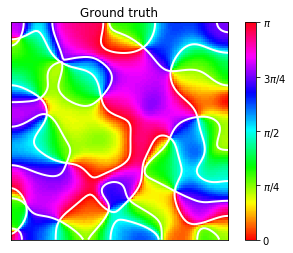

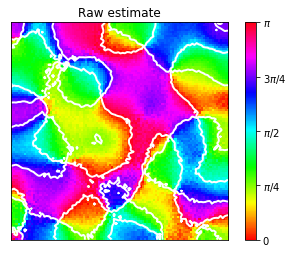

3.1414538538035135

In [10]:

# plot ground truth
plot_opm(m, title='Ground truth')
plt.show()

plot_opm(m_hat, title='Raw estimate')
plt.show()

((np.angle(m_hat) + np.pi) / 2).max()

We smoothe the raw estimate with a Gaussian kernel. The variance of the Gaussian kernel is chosen in order to optimize the correlation with the ground truth map. 

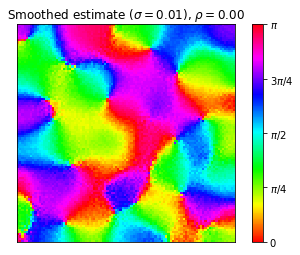

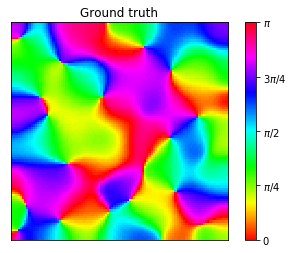

In [13]:
best_corr = -np.inf
best_sigma = np.nan
for sigma in 10**np.linspace(-2, 1, 50):
    
    # smoothe the estimate of the angle
    m_smooth = filters.gaussian_filter(M, sigma=(0, sigma, sigma))
    
    corr = ss.pearsonr(m_smooth[:2].reshape(-1), np.hstack((np.real(m), np.imag(m))).reshape(-1))[0]
    
    #plot_opm(m_smooth[0] + 1j * m_smooth[1], title=r'$\sigma = {0:.2f}$, $\rho = {1:.2f}$'.format(sigma, corr), pinwheels=False)
    #plt.show()
    
    if corr > best_corr:
        best_corr = corr
        best_sigma = sigma
        best_theta = m_smooth[0] + 1j * m_smooth[1]
        

plot_opm(best_theta, pinwheels=False,
         title=r'Smoothed estimate ($\sigma = {0:.2f}$), $\rho = {1:.2f}$'.format(best_sigma, best_corr))
plt.show()


plot_opm(m, title='Ground truth', pinwheels=False)
plt.show()

Now compare the preferred orientations of the ground truth map with the estimated map.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8e95f335c0>)

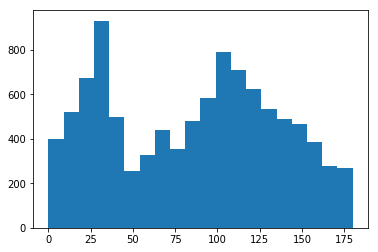

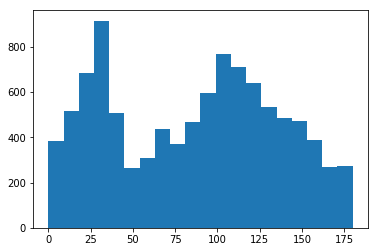

In [10]:
plot_orientation_histogram(m)

plot_orientation_histogram(m_hat)